In [1]:
%matplotlib inline

import os
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

In [4]:
dc = datacube.Datacube(app="Regression_test")

In [55]:
# setting some appropriate variables

lat = (-34,-34.5)
lon = (145,145.5)
time = ("2015-01-25","2015-02-22")

In [56]:
# querying for some data to test the regression against

query = {'x':lon,
        'y':lat,
        'time':time,
        'output_crs':'EPSG:3577',
        'resolution':(-25,25),
        'measurements':['nbart_swir_1','nbart_red','nbart_blue','nbart_green','nbart_swir_2','nbart_panchromatic','nbart_nir'],
        'group_by':'solar_day'
        }
regress = dc.load(product='ga_ls8c_ard_3',**query)

In [57]:
# NDVI indexing for use in the regreswsion comparison

regress['NDVI'] = (regress.nbart_nir-regress.nbart_red)/(regress.nbart_nir+regress.nbart_red)

In [58]:
# normalising the swir_1 (band 6) as an index relative to its maximum and minimum
swir_1_max = regress.nbart_swir_1.max()
swir_1_min = regress.nbart_swir_1.min()

regress["NSWIR"] = (regress.nbart_swir_1-swir_1_min)/(swir_1_max-swir_1_min)

In [59]:
print(regress)

<xarray.Dataset>
Dimensions:             (time: 1, x: 2056, y: 2407)
Coordinates:
  * time                (time) datetime64[ns] 2015-02-09T00:08:19.307218
  * y                   (y) float64 -3.771e+06 -3.772e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
Data variables:
    nbart_swir_1        (time, y, x) int16 3346 3278 3342 ... 2644 2588 2536
    nbart_red           (time, y, x) int16 1633 1587 1628 ... 1373 1367 1390
    nbart_blue          (time, y, x) int16 961 940 968 1002 ... 723 719 705 701
    nbart_green         (time, y, x) int16 1319 1275 1315 ... 1096 1067 1027
    nbart_swir_2        (time, y, x) int16 2706 2660 2708 ... 1944 1949 1997
    nbart_panchromatic  (time, y, x) int16 1420 1365 1413 ... 1111 1051 1029
    nbart_nir           (time, y, x) int16 2769 2706 2771 ... 2065 2072 2036
    NDVI                (time, y, x) float64 0.2581 0.2607 ... 0.205 0.1886
    NSWIR               (time, y, x) float64 0.507 0.4967 

In [60]:
regress.NSWIR

<xarray.DataArray 'NSWIR' (time: 1, y: 2407, x: 2056)>
array([[[0.506972, 0.496666, ..., 0.700515, 0.699454],
        [0.513489, 0.509245, ..., 0.720218, 0.714307],
        ...,
        [0.668536, 0.678994, ..., 0.409366, 0.409366],
        [0.664898, 0.670052, ..., 0.392089, 0.384207]]])
Coordinates:
  * time     (time) datetime64[ns] 2015-02-09T00:08:19.307218
  * y        (y) float64 -3.771e+06 -3.772e+06 ... -3.832e+06 -3.832e+06
  * x        (x) float64 1.187e+06 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06

In [61]:
# creating the constants for the analysis
c1 = 1.19104356*10**(-16)
c2 = 1.43876869*10**(-2)
wlen = 1.61*10**(-6)
K1 = c1/(wlen**5)
K2 = c2/wlen

regress["t_bright"] = K2/np.log((K1/regress.NSWIR)+1)-273.15

In [62]:
regress.t_bright

<xarray.DataArray 't_bright' (time: 1, y: 2407, x: 2056)>
array([[[17.852892, 17.658398, ..., 20.949699, 20.93503 ],
        [17.973981, 17.895296, ..., 21.218417, 21.13853 ],
        ...,
        [20.498138, 20.647985, ..., 15.840493, 15.840493],
        [20.445504, 20.51999 , ..., 15.438047, 15.248936]]])
Coordinates:
  * time     (time) datetime64[ns] 2015-02-09T00:08:19.307218
  * y        (y) float64 -3.771e+06 -3.772e+06 ... -3.832e+06 -3.832e+06
  * x        (x) float64 1.187e+06 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06

In [63]:
# creating the fractional cover index

regress["frac_cov"] = ((regress.NDVI-regress.NDVI.min())/(regress.NDVI.max()-regress.NDVI.min()))**2

In [64]:
# emissivity calculations
regress["em"] = 0.986-(0.986-0.928)*regress.frac_cov

In [65]:
# land surface temperature calculation

regress["lst"] = (regress.t_bright)/(1+((wlen*regress.t_bright)/c2)*np.log(regress.em))

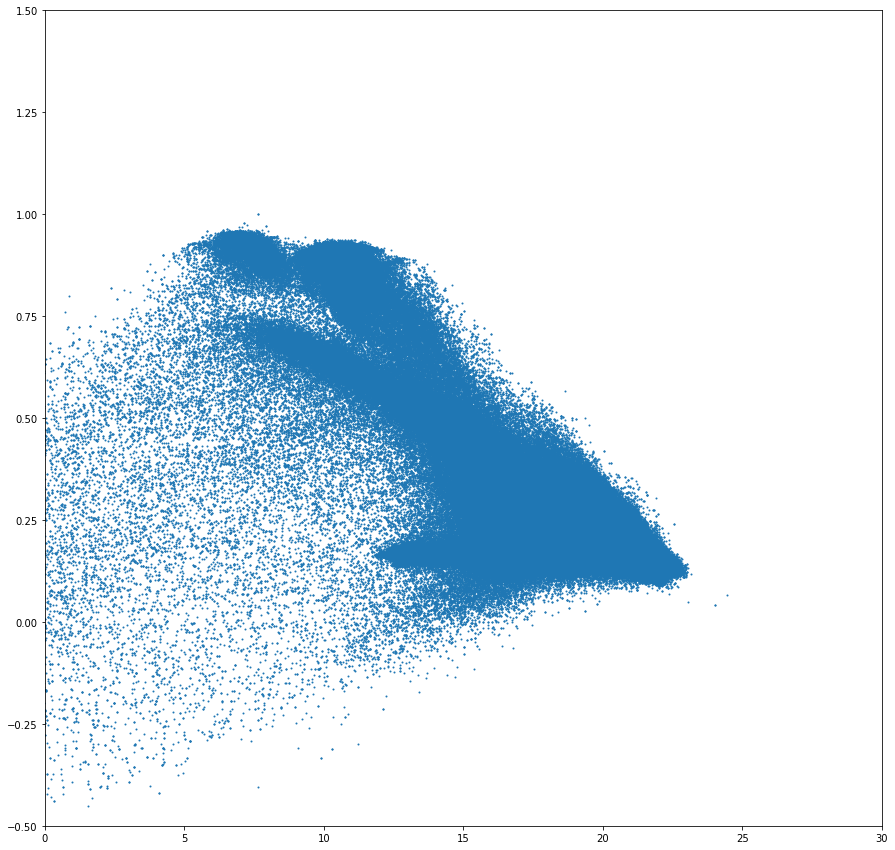

In [66]:
y_axis = regress.NDVI
x_axis = regress.lst

plt.figure(figsize=(15,15))
plt.scatter(x_axis,y_axis,s=1)
plt.ylim(-0.5,1.5)
plt.xlim(0,30)
plt.show()

In [68]:
display_map(x=lon,y=lat)

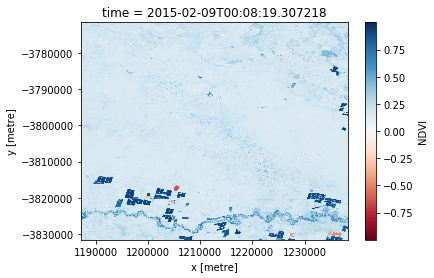

In [70]:
regress.NDVI.plot(cmap="RdBu")